In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger, ModelCheckpoint, EarlyStopping

In [3]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [4]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [5]:
y = train['label']
x = train.drop(labels=['label'], axis=1)

In [6]:
x = x.values.reshape(-1, 28, 28, 1)
# y = to_categorical(y, 10) # num_classes는 class갯수인가보다
test = test.values.reshape(-1, 28, 28, 1)

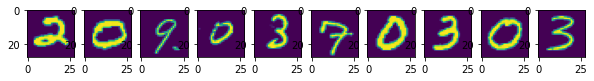

In [7]:
fig, axs = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    axs[i].imshow(test[i])
plt.show()

In [8]:
train_input, test_input, train_target, test_target = train_test_split(x, y, test_size=0.4, shuffle=True)


In [9]:
print(train_input.shape)
print(test_input.shape)
print(train_target.shape)
print(test_target.shape)

(25200, 28, 28, 1)
(16800, 28, 28, 1)
(25200,)
(16800,)


In [10]:
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.1, shuffle=True)

In [11]:
print(train_target[:5])

32025    9
34198    6
21169    1
11054    8
22951    8
Name: label, dtype: int64


In [12]:
print(train_input.shape)

(22680, 28, 28, 1)


In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                        input_shape=(28, 28, 1), padding='same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

2023-02-15 08:57:16.538552: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3

In [15]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')


In [16]:
checkpoint_cb = ModelCheckpoint('best-cnn-model.h5',
                               save_best_only=True)
early_stopping_cb = EarlyStopping(patience=2,
                                 restore_best_weights=True)


In [17]:
print(train_target.shape)
print(train_input.shape)

(22680,)
(22680, 28, 28, 1)


In [18]:
history = model.fit(train_input, train_target, 
                    epochs=20,
                   validation_data=(val_input, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])

2023-02-15 08:57:17.054091: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
709/709 [==============================] - 15s 20ms/step - loss: 1.3125 - accuracy: 0.7094 - val_loss: 0.1527 - val_accuracy: 0.9548
Epoch 2/20
709/709 [==============================] - 14s 20ms/step - loss: 0.3112 - accuracy: 0.9155 - val_loss: 0.1371 - val_accuracy: 0.9667
Epoch 3/20
709/709 [==============================] - 13s 19ms/step - loss: 0.2352 - accuracy: 0.9390 - val_loss: 0.0967 - val_accuracy: 0.9758
Epoch 4/20
709/709 [==============================] - 13s 19ms/step - loss: 0.2191 - accuracy: 0.9445 - val_loss: 0.1214 - val_accuracy: 0.9714
Epoch 5/20
709/709 [==============================] - 14s 20ms/step - loss: 0.2145 - accuracy: 0.9458 - val_loss: 0.1026 - val_accuracy: 0.9690


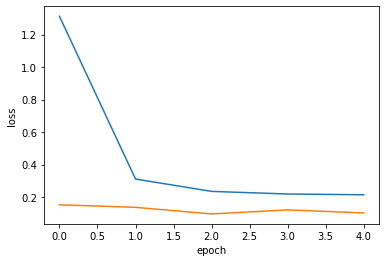

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [20]:
model.evaluate(test_input, test_target)

525/525 [==============================] - 4s 6ms/step - loss: 0.1018 - accuracy: 0.9726


[0.10183870047330856, 0.9726190567016602]

In [21]:
# print(test_input.shape)
# print(test_target.shape)
# print(train_input.shape)
# print(train_target.shape)
# print(val_input.shape)
# print(val_target.shape)
# y = to_categorical(test_target, 10)

In [22]:
# import numpy as np
# predicted_classes = np.argmax(model.predict(test_input), axis=1)
# correct_indices = np.nonzero(predicted_classes == y)[0]
# incorrect_indices = np.nonzero(predicted_classes != y)[0]

In [23]:
y_pred = model.predict(train_input) # 예측 값
y_predict = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

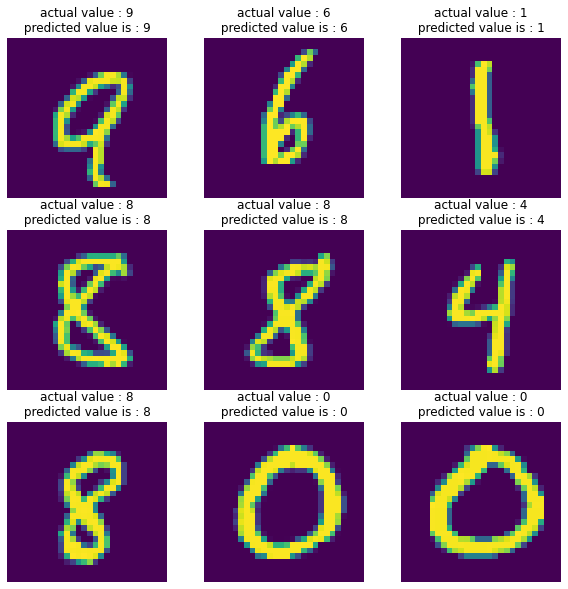

In [24]:
y_list = train_target.to_list()
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_input[i])
    plt.axis('off')
    plt.title('actual value : %d' %y_list[i]+ '\n predicted value is : %d ' % y_predict[i])

In [25]:
test = np.array(test)
test = test.reshape(len(test),28,28,1)

result = model.predict(test)

predicted_val=[]
for i in range(len(result)):
    predicted_val.append(np.argmax(result[i]))

In [26]:
submission = pd.DataFrame()
imgid=[]
for i in range(1, len(predicted_val)+1):
    imgid.append(i)
    
submission["Imageid"]=imgid
submission["Label"]=predicted_val

In [27]:
submission.head()

,Imageid,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [28]:
submission.to_csv('submission.csv',index=False)